# Academic test

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

### Parameters to be used 

In [2]:
T = 1
gamma = 1
alpha_g = 2
beta_g = 1.27 * 10**(-3)
sigma_g = 0.1863
r = 0.02

In [3]:
g_bar = 0.5
g_hat = 2*g_bar
b_hat = 1

## First Numerical Method 

### Parameters to be used 

In [4]:
omega = 2
eps = 10**(-5)

In [5]:
space_steps = 32
time_steps = 40

In [6]:
delta_tau = gamma/time_steps
tau_mesh = [n*delta_tau for n in range(time_steps+1)]

Remember: $\hat{B} \in [0,1]$ and $\hat{G} \in [0,1]$.

In [7]:
delta_B = 1/space_steps
B_mesh = [i*delta_B for i in range(space_steps+1)]

delta_G = 1/space_steps
G_mesh = [j*delta_G for j in range(space_steps+1)]

We must solve the linear system: $C(\hat{G})P_i^{n+1} = b_i^n$ at each time step and for each value of $i=1,2,\dots,N_{\hat{B}}-1$.

## Analytical Solution

In [8]:
def analytical_solution(B_hat, G_hat, tau):
    return np.exp(tau*(B_hat*b_hat)*(G_hat*g_hat - g_bar))

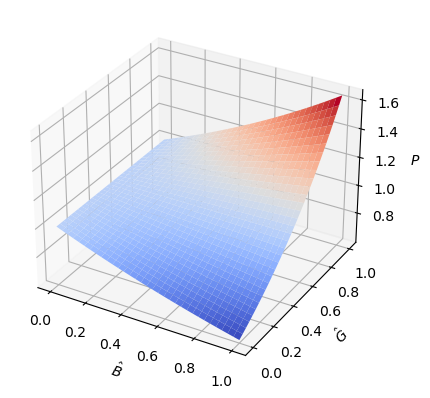

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
B_hat, G_hat = np.meshgrid(B_mesh, G_mesh)
Z = analytical_solution(B_hat, G_hat,1)
# Plot the surface.
ax.plot_surface(B_hat, G_hat, Z, cmap=cm.coolwarm)

# Tweak the limits and add latex math labels.
ax.set_xlabel(r'$\hat{B}$')
ax.set_ylabel(r'$\hat{G}$')
ax.set_zlabel(r'$P$')

plt.show()

In [10]:
def analytical_solution2(B, G_tilde, T = 1, t = 0):
    B_hat = B/b_hat
    G_hat = (G_tilde + g_bar)/g_hat
    return np.exp((T-t)*B_hat*G_hat)

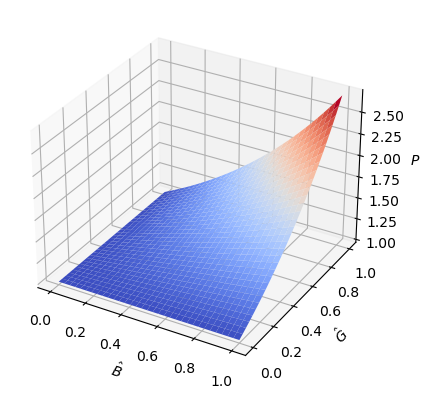

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
B_hat, G_hat = np.meshgrid(B_mesh, G_mesh)
B = B_hat * b_hat
G_tilde = G_hat * g_hat - g_bar
Z = analytical_solution2(B, G_tilde)

# Plot the surface.
ax.plot_surface(B_hat, G_hat, Z, cmap=cm.coolwarm)

# Tweak the limits and add latex math labels.
ax.set_xlabel(r'$\hat{B}$')
ax.set_ylabel(r'$\hat{G}$')
ax.set_zlabel(r'$P$')

plt.show()

### $C(\hat{G}) $ matrix 

In this academic test there is no seasonality, that is, $f=0$.

In [12]:
def f():
    return 0

In [13]:
def c1():
    c1_value = 1 + 0.5*r*delta_tau + 0.5* (g_hat**2 * sigma_g**2 * delta_tau)/(delta_G**2)
    return c1_value

def c2(j):
    c2_value = -0.5*(g_hat**2 * sigma_g**2 * delta_tau)/(2 * delta_G**2) - 0.5 * g_hat * alpha_g *\
    delta_tau * (f() - G_mesh[j]*g_hat-g_bar + beta_g*omega/(2*alpha_g))/(2*delta_G)
    return c2_value

def c3(j):
    c3_value = -0.5*(g_hat**2 * sigma_g**2 * delta_tau)/(2 * delta_G**2) + 0.5 * g_hat * alpha_g *\
    delta_tau * (f() - G_mesh[j]*g_hat-g_bar + beta_g*omega/(2*alpha_g))/(2*delta_G)
    return c3_value

In [14]:
def h(n,i,j):
    t = [T - tau_mesh[n] for n in range(len(tau_mesh))]
    G_tilde = [G_mesh[i] * g_hat - g_bar for i in range(len(G_mesh))]
    B = [B_mesh[i] * b_hat for i in range(len(G_mesh))]
    #G_hat = [G_mesh[i] for i in range(len(G_mesh))]
    #B_hat = [B_mesh[i] for i in range(len(G_mesh))]
    
    
    h_value = np.exp( (T - t[n]) * B[i] * G_tilde[j] ) * \
    (-B[i]*G_tilde[j] + 1/2 * sigma_g**2 * t[n]**2 * B[i]**2 - \
    t[n]*B[i]*alpha_g* (f() + (beta_g/alpha_g) * np.exp( (T - t[n])*B[i]*\
    G_tilde[j])-G_tilde[j] ) - np.exp(G_tilde[j]) * t[n] * G_tilde[j] -r)
    return h_value

In [15]:
C_matrix = [[0 for i in range(space_steps+1)] for j in range(space_steps+1)]

In [16]:
#main diagonal
for i in range(1,space_steps):
    C_matrix[i][i] = c1()
    
#top diagonal
for i in range(1,space_steps-1):
    C_matrix[i][i+1] = c2(i)
    
#bottom diagonal
for i in range(1,space_steps-1):
    C_matrix[i+1][i] = c3(i)
    
C_matrix[0][0] = 1
C_matrix[space_steps][space_steps] = 1

### $\left( b_i^n \right)_j$ vector 

This is a vector to be updated in each time step. First you solve the linear system and get to a array $P$ and then subtitute it on the right-hand side of the equation to get the $b$ vector.

In [17]:
def mult_factor1():
    m1_value = (1 - r*delta_tau*0.5) - (sigma_g**2 * g_hat**2 * delta_tau * 0.5)/(delta_G**2)
    return m1_value

def mult_factor3():
    m3_value = (sigma_g**2 * g_hat**2 * delta_tau * 0.5)/(2 * delta_G**2)
    return m3_value

def mult_factor5():
    m5_value = 0.5 * g_hat * delta_tau * beta_g / (4*delta_G)
    return m5_value


In [119]:
def m(theta, P, omega=2):
    if P + theta/(2*omega) <=0:
        a = -theta - 2*omega*P
        return a
    else:
        b = theta + 2*omega*P + omega**2 - omega * np.sqrt(4*theta + 8*omega*P + omega**2)
        return b

## Solving the linear system and updating values 

In [129]:
#Initializing the variables
P = [[1 for i in range(space_steps+1)] for j in range(time_steps+100)]
theta = [[1 for i in range(space_steps+1)] for j in range(time_steps+100)]

I am fixing the last i.

In [130]:
#remember to update boundary conditions
for n in range(time_steps+1):
    theta_n1 = theta.copy()
    P_n = P.copy()
    b = [0 for j in range(space_steps+1)]
    b[0] = analytical_solution(B_mesh[space_steps],G_mesh[0], tau_mesh[n])
    b[space_steps] = analytical_solution(B_mesh[space_steps],G_mesh[space_steps], tau_mesh[n]) #last i fixed
    
    #parameters to start the cycle
    criterion = 1
    k=0
    
    while np.abs(criterion) > eps and k<90:
        
        #constructing the b vector
        for j in range(1,space_steps):
            b[j] = mult_factor1()*P_n[k][j] +\
            ((alpha_g*g_hat*delta_tau*0.5 * (f()-G_mesh[j]*g_hat-g_bar + beta_g/alpha_g*P_n[k][j]))/(2*delta_G))*P_n[k][j+1] +\
            mult_factor3()*(P_n[k][j+1] + P_n[k][j-1])-\
            ((alpha_g*g_hat*delta_tau*0.5 * (f()-G_mesh[j]*g_hat-g_bar + beta_g/alpha_g*P_n[k][j]))/(2*delta_G))*P_n[k][j-1] +\
            mult_factor5()*(theta_n1[k][j+1]-theta_n1[k][j-1]) + \
            mult_factor5()*(theta_n1[0][j+1]-theta_n1[0][j-1]) -\
            h(n,space_steps,j) #i=1 fixed
        
        #########
        
        #solving the linear system
        newP = np.linalg.solve(C_matrix, b)
        P_n[k] = newP
        ######
        
        #update theta
        theta_updated = [m(theta_n1[k][j], newP[j]) for j in range(space_steps+1)] #check this
        theta_n1[k+1] = theta_updated
        ######
        
        #stopping test
        theta_updated_array = np.array(theta_updated)
        theta_k_array = np.array(theta_n1[k])
        numerator = np.max(theta_updated_array - theta_k_array)
        denominator = np.max(theta_updated_array)
        criterion = numerator/denominator
        #####
        k+=1
    print((k,criterion))
        
    theta[n] = theta_updated
    P[n] = newP


(4, -8.49747028668098e-06)
(4, -1.8154398481878244e-07)
(5, -1.0317775721402337e-09)
(6, -1.3957229662210004e-09)
(7, -2.6364502453262116e-07)
(8, -3.238254401885587e-07)
(9, -4.212850327661138e-08)
(10, -1.0744420743914415e-09)
(11, -1.375312711128201e-09)
(12, -1.5771443663615617e-09)
(13, -2.1527421677636545e-09)
(14, -3.3473910544210673e-09)
(15, -4.832153761049676e-09)
(16, -6.608734312264835e-09)
(17, -8.679898897156517e-09)
(18, -1.1054222751605953e-08)
(19, -1.3751477934632956e-08)
(20, -1.6808887368722298e-08)
(21, -2.0288865129490573e-08)
(22, -2.428891827784558e-08)
(23, -2.8955056813582436e-08)
(24, -3.4500630658038655e-08)
(25, -4.123389940720296e-08)
(26, -4.960012261511394e-08)
(27, -6.024833931578195e-08)
(28, -7.414250516213179e-08)
(29, -9.27560028771295e-08)
(30, -1.1843372227565287e-07)
(31, -1.551192405861593e-07)
(32, -2.0996388154217158e-07)
(33, -2.973824091855651e-07)
(34, -4.5136955240425903e-07)
(35, -7.757970943875469e-07)
(36, -1.8138159189998549e-06)
(39, 

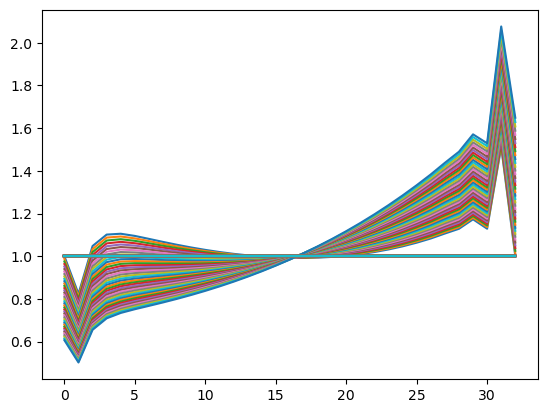

In [131]:
for i in range(len(P)):
    plt.plot(P[i])

In [132]:
analytical_solution(B_mesh[space_steps], G_mesh[space_steps],1)

1.6487212707001282

In [133]:
P[time_steps][-1]

1.6487212707001282

comparing the solution with j=32, i=1

Text(0.5, 1.0, 'Comparação com $B$ fixo, $t=0$')

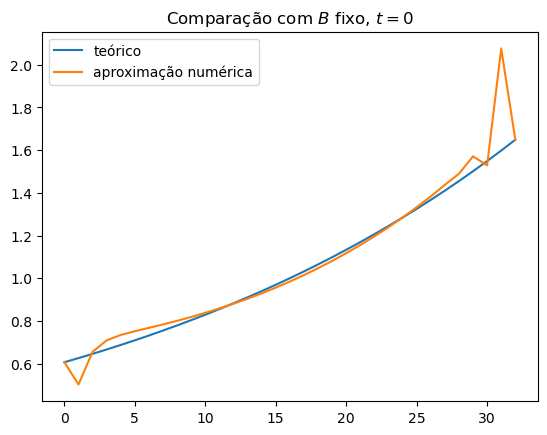

In [134]:
sol = []
for i in range(space_steps+1):
    sol.append(analytical_solution(B_mesh[space_steps],G_mesh[i], 1))
plt.plot(sol,label="teórico")
plt.plot(P[time_steps],label="aproximação numérica")
plt.legend()
plt.title("Comparação com $B$ fixo, $t=0$")

In [126]:
theta_n1

[[-0.9999999999999911,
  -0.9688704313753691,
  -0.9977151507501967,
  -0.9897031406150125,
  -0.9888708406013649,
  -0.9909279037155274,
  -0.9933832516538832,
  -0.9955024555651013,
  -0.9971406249403545,
  -0.9983229942534964,
  -0.9991201303876158,
  -0.9996117641462599,
  -0.9998756642208209,
  -0.99998339977956,
  -0.9999978868198545,
  -0.999971272261746,
  -0.9999427326870407,
  -0.9999360505626864,
  -0.9999569095065866,
  -0.9999898697830822,
  -0.9999949872495009,
  -0.9999040349346187,
  -0.9996162864389015,
  -0.9989937390961261,
  -0.9978563738942015,
  -0.9959718587497095,
  -0.9930818704946178,
  -0.9886658083449467,
  -0.983417622929073,
  -0.969900085252478,
  -0.9832873818479646,
  -0.7341784482307965,
  -0.9999999999999911],
 [-0.804283625720708,
  -0.5506355917518739,
  -0.7954206717690262,
  -0.9257905520809215,
  -0.9634830041625992,
  -0.9748000521278088,
  -0.9786115825220927,
  -0.9802790620243593,
  -0.9815695365862132,
  -0.9831104906215611,
  -0.98509278312